In [1]:
# Example 1: learning about spark and anomaly detection of a temperature dataset.
# Dataset: datasets/temperature.csv
# Author: Humberto Bianchini

In [2]:
# 1) Importing all necessary libraries and Spark session creation.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import DoubleType, IntegerType
spark = SparkSession.builder.appName("AnomalyDetection").getOrCreate()

In [3]:
# 2) Reading and showing the first rows of the dataset.
data = spark.read.format("csv").options(header="true", inferschema="true").load("temperature.csv")
data.show(5, False)

+-------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-----------------+-------------+-----+---------+---------+
|datetime           |Vancouver    |Portland     |San Francisco|Seattle      |Los Angeles  |San Diego    |Las Vegas    |Phoenix      |Albuquerque  |Denver       |San Antonio  |Dallas       |Houston      |Kansas City  |Minneapolis  |Saint Louis  |Chicago      |Nashville    |Indianapolis |Atlanta      |Detroit      |Jacksonville |Charlotte    |Miami        |Pittsburgh   |Toronto      |Philadelphia |New York     |Montreal     |Boston       |Beersheba    |Tel Aviv District|Eilat        

In [4]:
# 3) Showing the dataset columns.
data.columns

['datetime',
 'Vancouver',
 'Portland',
 'San Francisco',
 'Seattle',
 'Los Angeles',
 'San Diego',
 'Las Vegas',
 'Phoenix',
 'Albuquerque',
 'Denver',
 'San Antonio',
 'Dallas',
 'Houston',
 'Kansas City',
 'Minneapolis',
 'Saint Louis',
 'Chicago',
 'Nashville',
 'Indianapolis',
 'Atlanta',
 'Detroit',
 'Jacksonville',
 'Charlotte',
 'Miami',
 'Pittsburgh',
 'Toronto',
 'Philadelphia',
 'New York',
 'Montreal',
 'Boston',
 'Beersheba',
 'Tel Aviv District',
 'Eilat',
 'Haifa',
 'Nahariyya',
 'Jerusalem']

In [5]:
# 4) Showing the dataset rows count.
data.count()

45253

In [6]:
# 5) Choosing one city to analysis (Vancouver in this example) and showing the details.
dataAnalysis = data.select('datetime','Vancouver')
dataAnalysis.show(5)

+-------------------+-------------+
|           datetime|    Vancouver|
+-------------------+-------------+
|2012-10-01 12:00:00|         null|
|2012-10-01 13:00:00|       284.63|
|2012-10-01 14:00:00| 284.62904131|
|2012-10-01 15:00:00|284.626997923|
|2012-10-01 16:00:00|284.624954535|
+-------------------+-------------+
only showing top 5 rows



In [7]:
# 6) Filtering only data that don't have null values.
dataNotNull = dataAnalysis.filter(col('Vancouver').isNotNull())
dataNotNull.show(5)

+-------------------+-------------+
|           datetime|    Vancouver|
+-------------------+-------------+
|2012-10-01 13:00:00|       284.63|
|2012-10-01 14:00:00| 284.62904131|
|2012-10-01 15:00:00|284.626997923|
|2012-10-01 16:00:00|284.624954535|
|2012-10-01 17:00:00|284.622911147|
+-------------------+-------------+
only showing top 5 rows



In [8]:
# 7) Inserting index for the data.
df_plots = dataNotNull.withColumn("index", monotonically_increasing_id())
df_plots.show(5)

+-------------------+-------------+-----+
|           datetime|    Vancouver|index|
+-------------------+-------------+-----+
|2012-10-01 13:00:00|       284.63|    0|
|2012-10-01 14:00:00| 284.62904131|    1|
|2012-10-01 15:00:00|284.626997923|    2|
|2012-10-01 16:00:00|284.624954535|    3|
|2012-10-01 17:00:00|284.622911147|    4|
+-------------------+-------------+-----+
only showing top 5 rows



In [9]:
# 8) Calculating the "Mean" and "Standard Deviation" of data.
list_stats = dataNotNull.select(avg(col('Vancouver')).alias('mean'),stddev(col('Vancouver')).alias('stdDev')).collect()
mean = list_stats[0]['mean']
dev = list_stats[0]['stdDev']
print(f"Mean: {mean}")
print(f"Standard deviation: {dev}")

Mean: 283.8626537415422
Standard deviation: 6.64013061677093


In [10]:
# 9) Creating a new dataframe with the stats.

df_stats = dataNotNull.select(avg('Vancouver').alias('mean'), stddev('Vancouver').alias('stdDev'))
df_stats.show()

+-----------------+----------------+
|             mean|          stdDev|
+-----------------+----------------+
|283.8626537415422|6.64013061677093|
+-----------------+----------------+



In [11]:
# 10) Describing the dataset
dataNotNull.describe().show()

+-------+-------------------+-----------------+
|summary|           datetime|        Vancouver|
+-------+-------------------+-----------------+
|  count|              44458|            44458|
|   mean|               null|283.8626537415422|
| stddev|               null| 6.64013061677093|
|    min|2012-10-01 13:00:00|           245.15|
|    max|2017-10-28 00:00:00|            307.0|
+-------+-------------------+-----------------+



In [12]:
# 11) Setting two functions to calculate anomalies.

def distance(x):
  mean = 283.8626
  dev = 6.6401
  return ((x - mean)/dev)


def anomalies(x):
  dev = 6.6401
  if (x > 2):
    return 1
  else:
    return 0

  

distance_udf_double = udf(lambda z: distance(z), DoubleType())
anomalies_udf_int = udf(lambda z: anomalies(z), IntegerType())

In [13]:
# 12) Calculating the distances between a temperature value and the mean.
data_new = dataNotNull.select('Vancouver',distance_udf_double('Vancouver').alias('distance'))
data_new.show(5)

+-------------+-------------------+
|    Vancouver|           distance|
+-------------+-------------------+
|       284.63|0.11557054863631709|
| 284.62904131|0.11542616978660031|
|284.626997923|0.11511843541512777|
|284.624954535| 0.1148107008930567|
|284.622911147|0.11450296637099419|
+-------------+-------------------+
only showing top 5 rows



In [14]:
from pyspark.sql.functions import abs
data_new=data_new.select('Vancouver','distance', abs(col('distance')).alias("ABSdistance"))
data_new.show(5)

+-------------+-------------------+-------------------+
|    Vancouver|           distance|        ABSdistance|
+-------------+-------------------+-------------------+
|       284.63|0.11557054863631709|0.11557054863631709|
| 284.62904131|0.11542616978660031|0.11542616978660031|
|284.626997923|0.11511843541512777|0.11511843541512777|
|284.624954535| 0.1148107008930567| 0.1148107008930567|
|284.622911147|0.11450296637099419|0.11450296637099419|
+-------------+-------------------+-------------------+
only showing top 5 rows



In [15]:
data_new = data_new.select('Vancouver','distance', "ABSdistance", anomalies_udf_int("ABSdistance").alias("isAnomaly"))
data_new.show(10)

+-------------+-------------------+-------------------+---------+
|    Vancouver|           distance|        ABSdistance|isAnomaly|
+-------------+-------------------+-------------------+---------+
|       284.63|0.11557054863631709|0.11557054863631709|        0|
| 284.62904131|0.11542616978660031|0.11542616978660031|        0|
|284.626997923|0.11511843541512777|0.11511843541512777|        0|
|284.624954535| 0.1148107008930567| 0.1148107008930567|        0|
|284.622911147|0.11450296637099419|0.11450296637099419|        0|
|284.620867759| 0.1141952318489231| 0.1141952318489231|        0|
|284.618824371|0.11388749732685204|0.11388749732685204|        0|
|284.616780983|0.11357976280478096|0.11357976280478096|        0|
|284.614737595| 0.1132720282827099| 0.1132720282827099|        0|
|284.612694207|0.11296429376063881|0.11296429376063881|        0|
+-------------+-------------------+-------------------+---------+
only showing top 10 rows



In [16]:
# 13) Showing the found anomalies.
data_new.filter(col("isAnomaly")>0).show(10)

+---------+-------------------+------------------+---------+
|Vancouver|           distance|       ABSdistance|isAnomaly|
+---------+-------------------+------------------+---------+
|   270.42|-2.0244574629900107|2.0244574629900107|        1|
|   269.81|-2.1163235493441337|2.1163235493441337|        1|
|   269.65| -2.140419571994399| 2.140419571994399|        1|
|   269.67|-2.1374075691631105|2.1374075691631105|        1|
|   269.67|-2.1374075691631105|2.1374075691631105|        1|
|   270.52|-2.0093974488336026|2.0093974488336026|        1|
|   269.15|-2.2157196427764654|2.2157196427764654|        1|
|   267.15|-2.5169199259047317|2.5169199259047317|        1|
|   266.15| -2.667520067468865| 2.667520067468865|        1|
|   266.15| -2.667520067468865| 2.667520067468865|        1|
+---------+-------------------+------------------+---------+
only showing top 10 rows



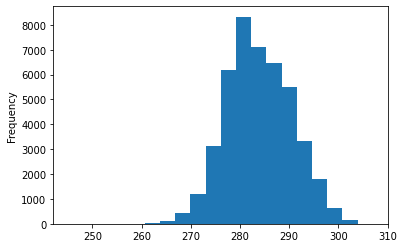

In [17]:
df = dataNotNull.toPandas()
df.head()
df['Vancouver'].plot(kind='hist', bins=20);

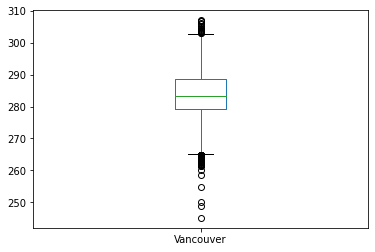

In [18]:
df['Vancouver'].plot(kind='box');